In [133]:
from systemml import MLContext, dml, jvm_stdout
ml = MLContext(sc)


In [134]:
from itertools import chain
from pyspark.sql import DataFrame


def _sort_transpose_tuple(tup):
    x, y = tup
    return x, tuple(zip(*sorted(y, key=lambda v_k: v_k[1], reverse=False)))[0]


def transpose(X):
    """Transpose a PySpark DataFrame.

    Parameters
    ----------
    X : PySpark ``DataFrame``
        The ``DataFrame`` that should be tranposed.
    """
    # validate
    if not isinstance(X, DataFrame):
        raise TypeError('X should be a DataFrame, not a %s' 
                        % type(X))

    cols = X.columns
    n_features = len(cols)

    # Sorry for this unreadability...
    return X.rdd.flatMap( # make into an RDD
        lambda xs: chain(xs)).zipWithIndex().groupBy( # zip index
        lambda val_idx: val_idx[1] % n_features).sortBy( # group by index % n_features as key
        lambda grp_res: grp_res[0]).map( # sort by index % n_features key
        lambda grp_res: _sort_transpose_tuple(grp_res)).map( # maintain order
        lambda key_col: key_col[1]).toDF() # return to DF

In [135]:
X = spark.createDataFrame([1,2,3,4,5,6],IntegerType())

In [136]:
X.show()

+-----+
|value|
+-----+
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
+-----+



In [137]:
Xt = transpose(X)

In [138]:
Xt

DataFrame[_1: bigint, _2: bigint, _3: bigint, _4: bigint, _5: bigint, _6: bigint]

# LSTM start

In [139]:
script = """
source("nn/layers/affine.dml") as affine
source("nn/layers/conv2d_builtin.dml") as conv2d
source("nn/layers/cross_entropy_loss.dml") as cross_entropy_loss
source("nn/layers/dropout.dml") as dropout
source("nn/layers/l2_reg.dml") as l2_reg
source("nn/layers/max_pool2d_builtin.dml") as max_pool2d
source("nn/layers/relu.dml") as relu
source("nn/layers/softmax.dml") as softmax
source("nn/layers/sigmoid.dml") as sigmoid
source("nn/optim/sgd_nesterov.dml") as sgd_nesterov
source("nn/layers/lstm.dml") as lstm
#


[W1, b1, out01, c01] = lstm::init(1,1,1)



feedForward = function (matrix[double] X,
                        matrix[double] W,
                        matrix[double] b,
                        matrix[double] out0, matrix[double] c0) 
                    return (matrix[double] z2,
                            matrix[double] a2,
                            matrix[double] c,
                            matrix[double] cache_out,
                            matrix[double] cache_c,
                            matrix[double] cache_ifog) {
    T = length(X)
    [z2, c, cache_out, cache_c, cache_ifog] = lstm::forward(X, W, b,T,1,TRUE,out0,c0)
    a2 = sigmoid::forward(z2)
}

gradient = function(matrix[double] X,
                        matrix[double] W,
                        matrix[double] b,
                        matrix[double] out0, matrix[double] c0) 
                    return (matrix[double] dX,
                        matrix[double] dW,
                        matrix[double] db,
                        matrix[double] dout0,
                        matrix[double] dc0) {
    #Compute derivative with respect to W and W2 for a given X and y:
    [z2, a2, c, cache_out, cache_c, cache_ifog] = feedForward(X,W,b,out0,c0)
    loss = cross_entropy_loss::backward(X, a2)
    
    smpz3 =  sigmoid::backward(loss,z2) 
    T = length(X)
    [dX,dW,db,dout0,dc0] = lstm::backward(smpz3,c,X,W,b,T,1,TRUE,out0,c0,cache_out, cache_c, cache_ifog)
    
}





max_iterations = 10000
iter = 0
learningRate = 0.001



while( iter < max_iterations ){
   [a2,z2, c, cache_out, cache_c, cache_ifog] = feedForward(X,W1,b1,out01,c01)
   [dX,dW,db,dout0,dc0] = gradient(X,W1,b1,out01,c01)
   #print (toString(W1)) 
   #print (toString(dW))
    #update
    #W1 = W1 - dW
    W1 = W1 - learningRate * dW 
    iter = iter + 1
    if (iter %% 100 == 0) {
        loss = cross_entropy_loss::backward(X, a2)
        print (toString(loss))
    }
}

[a2,z2, c, cache_out, cache_c, cache_ifog] = feedForward(X,W1,b1,out01,c01)

"""


In [140]:
prog = dml(script).input(X=Xt)

with jvm_stdout():
    result = ml.execute(prog)

a2 = result.get("a2").toNumPy()
print a2

#loss = result.get("dW").toNumPy()
#print loss

0.168 0.102 0.058 0.034 0.021 0.013

0.166 0.100 0.057 0.033 0.020 0.012

0.165 0.099 0.056 0.032 0.019 0.012

0.164 0.098 0.055 0.032 0.019 0.011

0.163 0.096 0.054 0.031 0.018 0.011

0.162 0.095 0.053 0.030 0.018 0.011

0.160 0.094 0.052 0.030 0.017 0.010

0.159 0.093 0.051 0.029 0.017 0.010

0.158 0.092 0.050 0.028 0.016 0.010

0.157 0.091 0.050 0.028 0.016 0.009

0.156 0.090 0.049 0.027 0.016 0.009

0.154 0.089 0.048 0.027 0.015 0.009

0.153 0.088 0.047 0.026 0.015 0.009

0.152 0.087 0.047 0.026 0.015 0.008

0.151 0.086 0.046 0.025 0.014 0.008

0.150 0.085 0.045 0.025 0.014 0.008

0.148 0.084 0.045 0.024 0.014 0.008

0.147 0.083 0.044 0.024 0.013 0.007

0.146 0.082 0.043 0.023 0.013 0.007

0.145 0.081 0.043 0.023 0.013 0.007

0.144 0.081 0.042 0.023 0.012 0.007

0.142 0.080 0.042 0.022 0.012 0.007

0.141 0.079 0.041 0.022 0.012 0.006

0.140 0.078 0.041 0.021 0.011 0.006

0.139 0.077 0.040 0.021 0.011 0.006

0.137 0.076 0.039 0.021 0.011 0.006

0.136 0.076 0.039 0.020 0.011 0.006

0

In [6]:
import numpy as np
fs = 44100       # sampling rate, Hz, must be integer
duration = 0.01
f = 440.0        # sine frequency, Hz, may be float
sine = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
cosine = (np.cos(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
tangens = (np.tan(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)

In [7]:
from pyspark.sql.types import *
#,samples.tolist()
data = zip(range(len(sine)),sine.tolist(),cosine.tolist(),tangens.tolist())

In [8]:
#ts = spark.createDataFrame(range(len(samples)), IntegerType()).toDF("ts")
signal = spark.createDataFrame(data).toDF("ts","sine","cosine","tangens")

In [9]:
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully


/usr/local/src/bluemix_jupyter_bundle.v55/notebook/lib/python2.7/site-packages/bokeh/core/json_encoder.py:52: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  NP_EPOCH = np.datetime64('1970-01-01T00:00:00Z')


Table service_connections created successfully



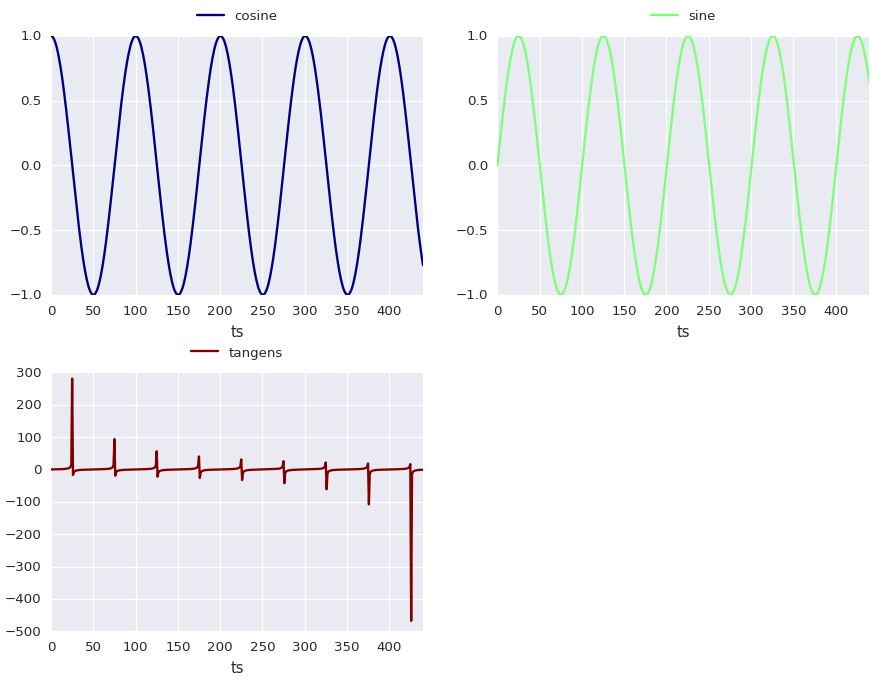

In [10]:
display(signal)

In [11]:
signale_no_ts = signal.select("sine","cosine","tangens")

In [23]:

prog = dml(script).input(X=signale_no_ts).input(y=signale_no_ts).output("YhatBefore").output("YhatAfter")

result = ml.execute(prog)

YhatBefore = result.get("YhatBefore").toNumPy()
YhatAfter = result.get("YhatAfter").toNumPy()
print YhatBefore
print YhatAfter

[[ 0.59025089  0.36394841  0.66829671]
 [ 0.58769498  0.35608111  0.6648368 ]
 [ 0.58579272  0.34868366  0.66152219]
 ..., 
 [ 0.72966429  0.42788427  0.70478662]
 [ 0.73168465  0.42353137  0.70201033]
 [ 0.73405932  0.42043875  0.69978748]]
[[ 0.99026392  0.99301944  0.99182016]
 [ 0.99019159  0.99284173  0.99182841]
 [ 0.99013668  0.99266206  0.99183744]
 ..., 
 [ 0.99353218  0.9906477   0.98875765]
 [ 0.99355399  0.99053411  0.98892149]
 [ 0.99358869  0.99046573  0.98910023]]


In [13]:
def sse(y,yhat):
    return sum(map(lambda (a,b) : pow(a[0]-b[0],2),zip(y,yhat)))
print sse(y,YhatBefore)
print sse(y,YhatAfter)

97.6044646533
71.718628891


In [14]:
signale_no_ts.select("sine").show()

+-------------------+
|               sine|
+-------------------+
|                0.0|
|0.06264832615852356|
|0.12505052983760834|
|0.18696144223213196|
|0.24813784658908844|
| 0.3083394169807434|
|0.36732959747314453|
| 0.4248766601085663|
|  0.480754554271698|
| 0.5347436666488647|
| 0.5866320133209229|
| 0.6362156271934509|
| 0.6832997798919678|
| 0.7276994585990906|
| 0.7692402601242065|
| 0.8077589869499207|
| 0.8431042432785034|
| 0.8751372694969177|
| 0.9037321209907532|
| 0.9287765622138977|
+-------------------+
only showing top 20 rows



In [19]:
transpose(signale_no_ts.select("sine")).show()

+---+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-----------------+-------------------+------------------+-------------------+--------------------+--------------------+------------------